# Peptide Retention Time Prediction using Encoder-Only Transformer – Evaluation & Test Notebook

This notebook loads a trained Encoder-Only Transformer model and evaluates it on validation/test data, and shows how to predict RT for new peptide sequences.

---

## 1. Setup & Imports

In [7]:
import sys
sys.path.append('./src')

from rt_transformer import AATokenizer, PeptideRTDataset, PeptideRTEncoderModel, split_dataset, collate, compute_metrics

import torch
from torch import nn
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader

import numpy as np

## 2. Configuration
Set data and saved model paths and model hyperparameters (must match training!).

In [8]:
DATA_PATH = "data/cysty.txt"
MODEL_PATH = "models/hpo/misc_dia/best_encoder.pt"
VAL_RATIO = 1 # 1 for entire dataset evaluation

D_MODEL = 160
N_HEADS = 8
N_LAYERS = 5

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", DEVICE)

Using device: cuda


## 3. Load Data and Model

In [9]:
# Tokenizer and dataset
tokenizer = AATokenizer()
dataset = PeptideRTDataset(DATA_PATH, tokenizer)
print(f"Dataset size: {len(dataset)} samples")

# Use the same split as in training
_, val_ds = split_dataset(dataset, val_ratio=VAL_RATIO, seed=42)
coll = lambda b: collate(b, tokenizer.pad_id)
val_loader = DataLoader(val_ds, batch_size=256, shuffle=False, collate_fn=coll)

# Model
model = PeptideRTEncoderModel(
    tokenizer,
    d_model=D_MODEL,
    n_heads=N_HEADS,
    d_ff=4*D_MODEL,
    n_layers=N_LAYERS
)

#if torch.cuda.is_available():
#    model = nn.DataParallel(model)

model=model.to(DEVICE)

model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
print(f"Model size: {sum(p.numel() for p in model.parameters() if p.requires_grad)} parameters")

Dataset size: 11041 samples
Model size: 1576802 parameters


## 4. Evaluate on Validation Set

In [10]:
# Get predictions and targets
all_preds, all_targets, all_peptides = [], [], []

with torch.no_grad():
    model.eval()
    for batch in val_loader:
        seqs, mask, rts = batch
        seqs, mask = seqs.to(DEVICE), mask.to(DEVICE)
        preds = model(seqs, mask).cpu().numpy()

        all_preds.append(preds)
        all_targets.append(rts.numpy())

        # Decode each sequence in the batch
        # seqs is a tensor of shape (batch_size, seq_len)
        decoded_batch = [dataset.tok.decode(seq.cpu().tolist()) for seq in seqs]
        all_peptides.extend(decoded_batch)

all_preds = np.concatenate(all_preds)
all_targets = np.concatenate(all_targets)

Compute main metrics.

In [11]:
# Convert numpy arrays to torch tensors
all_preds_torch = torch.tensor(all_preds)
all_targets_torch = torch.tensor(all_targets)

metrics = compute_metrics(all_preds_torch, all_targets_torch)
print("\nValidation metrics for model:")
for k, v in metrics.items():
    print(f"{k:26s}: {v:.5f}")


Validation metrics for model:
MAE                       : 0.07756
MSE                       : 0.00800
RMSE                      : 0.08943
Max_Abs_Error             : 0.75099
Median_Abs_Error          : 0.08083
Mean_Abs_Percentage_Error : inf
Std_Error                 : 0.06828
Std_True                  : 0.22598
Std_Pred                  : 0.17419
R2                        : 0.84337
Explained_Variance        : 0.90870
Pearson                   : 0.97485
Spearman                  : 0.98273


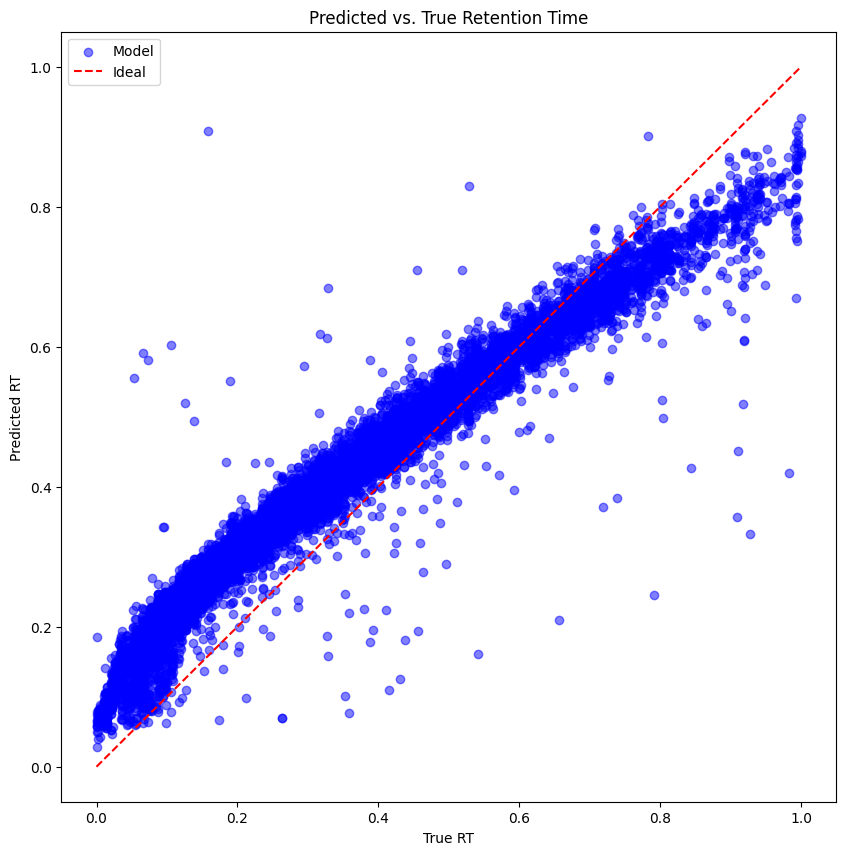

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
plt.scatter(all_targets, all_preds, alpha=0.5, label="Model", color="blue")
plt.xlabel("True RT")
plt.ylabel("Predicted RT")
plt.title("Predicted vs. True Retention Time")
plt.plot([all_targets.min(), all_targets.max()],
         [all_targets.min(), all_targets.max()], 'r--', label="Ideal")
plt.legend()
plt.show()

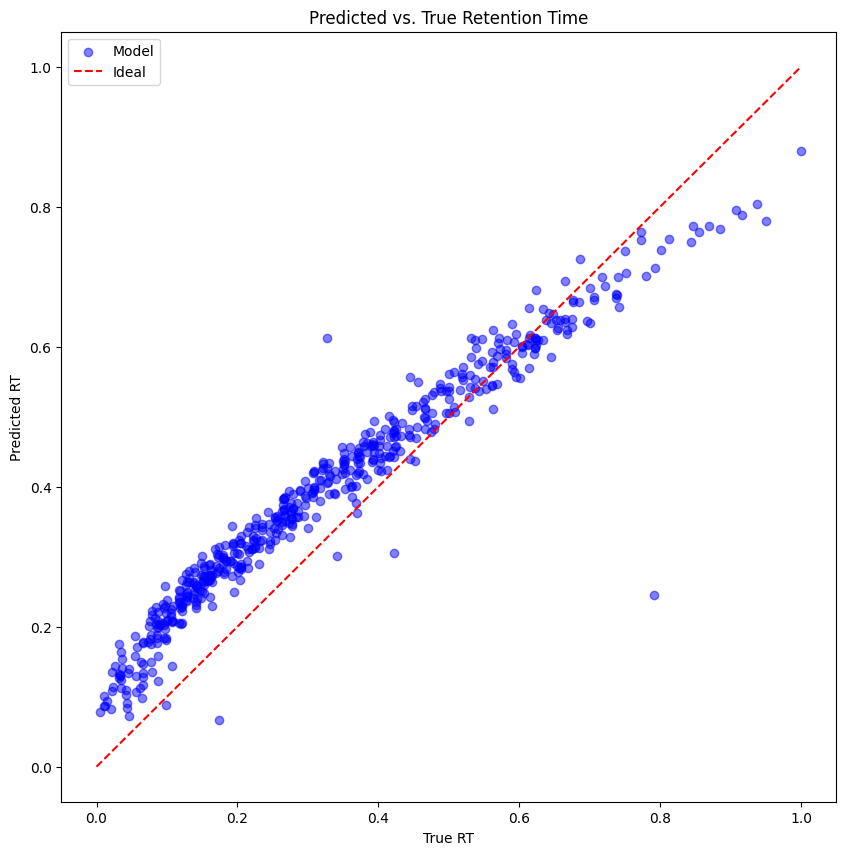

In [13]:
plt.figure(figsize=(10, 10))
plt.scatter(all_targets[:552], all_preds[:552], alpha=0.5, label="Model", color="blue")
plt.xlabel("True RT")
plt.ylabel("Predicted RT")
plt.title("Predicted vs. True Retention Time")
plt.plot([all_targets.min(), all_targets.max()],
         [all_targets.min(), all_targets.max()], 'r--', label="Ideal")
plt.legend()
plt.show()